# Exploratory data analysis (EDA)

::::{grid}

:::{grid-item-card}
**Lecture learning goals**
^^^

By the end of the lecture you will be able to:

1. Visualize missing values.
2. Define what EDA is on a conceptual levels both for numerical and categorical variables.
3. Use repeated plot grids to investigate multiple data frame columns in the same plot.
4. Visualize correlations.
5. Visualize counts of categorical variables.
:::

:::{grid-item-card}
**Required activities**
^^^

Before class:
- [This 10 min video on EDA concepts](https://ubcca-my.sharepoint.com/:v:/g/personal/joel_ostblom_ubc_ca/ETctjEToFRlJr38d8jqcOHMBRnJFHLlY0JHKXYLrD8Brvw?e=oZ9b59).

After class:
- Review the lecture notes.
- [Interactive flow chart](https://www.data-to-viz.com/) for which visualization to choose. Not really anything to read, but go there to look around and bookmark it to use as a reference when needed throughout this course and others.

:::
::::

In [1]:
import altair as alt
import pandas as pd

# Simplify working with large datasets in Altair
alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

## Missing values

### Py

First we are going to load in some weather data and simulate a faulty sensor by assigning some NaN values manually.

In [2]:
from vega_datasets import data
import numpy as np


df = data.seattle_weather()
# Artifically introduce some NaNs to simulate a sensor that can't measure below freezing
df.loc[df['temp_min'] <= 0.6, 'temp_min'] = np.nan
df.loc[df['temp_max'] <= 0.6, 'temp_max'] = np.nan
df = df[df['weather'].isin(['rain', 'snow', 'sun'])]
df

,date,precipitation,temp_max,temp_min,wind,weather
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
5,2012-01-06,2.5,4.4,2.2,2.2,rain
...,...,...,...,...,...,...
1442,2015-12-13,1.3,7.8,6.1,6.1,sun
1443,2015-12-14,0.0,7.8,1.7,1.7,sun
1455,2015-12-26,0.0,4.4,NaN,2.5,sun
1459,2015-12-30,0.0,5.6,NaN,3.4,sun


If we were to visualize this data 
in order to answer the the question
"what what the minimum temperature each year for the difference types of weather?"
it might look something like this:

In [3]:
alt.Chart(df).mark_point(size=120, opacity=0.7).encode(
    y='year(date):N',
    x='min(temp_min)',
    color='weather',
    shape='weather'
)

alt.Chart(...)

One immediate drawback with this visualization is that there could be overlapping dots in the exact same spot
which make it difficult to see the exact values from each weather type.
This chart still reveals something peculiar about our data:
it looks like the dots are neatly arranged in a grid around the lowest temperature for each year.
Almost too neat... this might be due to some binning on the data or maybe that the resolution of the sensor is low.
There is also probably something going where the lowest values are clamped to just over one degree celsius,
that seems quite odd as we would expect some variation in the yearly minimum temperature as well.
This could be due to some error in how the data was pre-processed
or maybe that the sensor mechanics don't tolerate values under freezing
and it stops measuring during that time.

In general when we read in data,
it is a good idea to perform some EDA on the missing values before starting to do it on the rest of the data,
regardless of whether we have already observed a weird pattern or not.
`df.info()` can show us how many missing values there are,
but we don't get any info on their pattern.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 1 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           996 non-null    datetime64[ns]
 1   precipitation  996 non-null    float64       
 2   temp_max       991 non-null    float64       
 3   temp_min       910 non-null    float64       
 4   wind           996 non-null    float64       
 5   weather        996 non-null    object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 86.8+ KB


To see if there is a pattern in the missing values, 
the simplest we could do would be to use pandas built in styling functions.
This produces quite long output,
so I have truncated it here,
but if you were to scroll through it 
you would see that there seems to be a periodicity to the data
and since this data set is ordered by the date the measurement was collected
it seems like this periodic variation is through time.

In [5]:
df[:50].style.highlight_null()

,date,precipitation,temp_max,temp_min,wind,weather
1,2012-01-02 00:00:00,10.900000,10.600000,2.800000,4.500000,rain
2,2012-01-03 00:00:00,0.800000,11.700000,7.200000,2.300000,rain
3,2012-01-04 00:00:00,20.300000,12.200000,5.600000,4.700000,rain
4,2012-01-05 00:00:00,1.300000,8.900000,2.800000,6.100000,rain
5,2012-01-06 00:00:00,2.500000,4.400000,2.200000,2.200000,rain
6,2012-01-07 00:00:00,0.000000,7.200000,2.800000,2.300000,rain
7,2012-01-08 00:00:00,0.000000,10.000000,2.800000,2.000000,sun
8,2012-01-09 00:00:00,4.300000,9.400000,5.000000,3.400000,rain
9,2012-01-10 00:00:00,1.000000,6.100000,nan,3.400000,rain
10,2012-01-11 00:00:00,0.000000,6.100000,nan,5.100000,sun


We could create a more effective visualization of this using Altair,
but it would be a bit involved as you can see below.
The reason we are melting the data
is so that we can perform this viz for all the columns
since we don't know where the EDA values are when we do EDA.
If you are only interested in one column,
you could skip the melting part.

In [6]:
alt.Chart(
    df.isna().reset_index().melt(
        id_vars='index'
    )
).mark_rect().encode(
    alt.X('index:O').axis(None),
    alt.Y('variable').title(None),
    alt.Color('value').title('NaN'),
    alt.Stroke('value')  # We set the stroke which is the outline of each rectangle in the heatmap
).properties(
    width=df.shape[0]
)

alt.Chart(...)

Aha! Here we can clearly see the periodic pattern in the data.
There is a predictable reoccurrence of the missing values.
Again,
remember that this data is ordered by time
even thought we are using the index when plotting it
to make sure this technique works with dataframe that do not have a date column.

We could explore what this patterns is due to
by sorting the data by another variable.
Let's test our hypothesis that the sensor
can't measure low temperatures.
If this is true,
we should see that all the temp_min values bunch up
to the left since this is also where the lowest temp_max temparatures are
(a day with a low max temperature is more likely to have a low min temperature).

In [7]:
alt.Chart(
    df.sort_values(
        'temp_max',
        ignore_index=True
    ).isna().reset_index().melt(
        id_vars='index'
    )
).mark_rect().encode(
    alt.X('index:O').axis(None),
    alt.Y('variable').title(None),
    alt.Color('value').title('NaN'),
    alt.Stroke('value')
).properties(
    width=df.shape[0]
)

alt.Chart(...)

There does indeed seem like the missing values are related to low daily temperatures!
(to the far right you can see the values that are NaN for both the max and min temperature,
NaNs are sorted after all numerical values in pandas).

We could have used the sorting technique with the pandas styler as well:

In [8]:
# Just showing the first 50 to save space
df.sort_values('temp_max')[:50].style.highlight_null()

,date,precipitation,temp_max,temp_min,wind,weather
708,2013-12-09 00:00:00,0.000000,1.100000,nan,1.300000,sun
704,2013-12-05 00:00:00,0.000000,1.100000,nan,2.600000,sun
705,2013-12-06 00:00:00,0.000000,1.100000,nan,4.700000,sun
14,2012-01-15 00:00:00,5.300000,1.100000,nan,3.200000,snow
15,2012-01-16 00:00:00,2.500000,1.700000,nan,5.000000,snow
378,2013-01-13 00:00:00,0.000000,2.200000,nan,1.500000,sun
707,2013-12-08 00:00:00,0.000000,2.200000,nan,2.200000,sun
765,2014-02-04 00:00:00,0.000000,2.800000,nan,4.700000,sun
377,2013-01-12 00:00:00,0.000000,2.800000,nan,2.000000,sun
1064,2014-11-30 00:00:00,0.000000,2.800000,nan,4.400000,sun


The missing values in our case were directly related to the column itself,
low `temp_min` values meant that they were missing.
Values could also be missing seemingly randomly,
or depending on another column in the data frame.
These three types of missing values are sometimes called:

- Missing not at random - Depends on the value in the column itself
- Missing at random - Depends on the value in another column
- Missing completely at random - Doesn't seem to depend on any other *measured* variable

The underlying reasons for missing values can be quite domain specific,
e.g. a medical doctor might be missing blood pressure measurements for younger adults
than for older adults since that information might be more valuable for older people.
In this case we would say that the values are missing at random
since there is no relation between the actual blood pressure reading and whether a value goes missing
but there is a relation to the patients age
which would be another variable in our dataset
(it is more important you remember these principles than memorizing the exact names).
There are [more discussion of these concepts in this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4121561/).

### R

There is no styler function in dplyer like in pandas,
so we will go straight to showing a summary and creating the heatmap:

In [9]:
%load_ext rpy2.ipython

In [10]:
%%R -i df
library(tidyverse)

df |> glimpse()

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 996
Columns: 6
$ date          <dttm> 2012-01-02, 2012-01-03, 2012-01-04, 2012-01-05, 2012-01…
$ precipitation <dbl> 10.9, 0.8, 20.3, 1.3, 2.5, 0.0, 0.0, 4.3, 1.0, 0.0, 0.0,…
$ temp_max      <dbl> 10.6, 11.7, 12.2, 8.9, 4.4, 7.2, 10.0, 9.4, 6.1, 6.1, 6.…
$ temp_min      <dbl> 2.8, 7.2, 5.6, 2.8, 2.2, 2.8, 2.8, 5.0, NaN, NaN, NaN, N…
$ wind          <dbl> 4.5, 2.3, 4.7, 6.1, 2.2, 2.3, 2.0, 3.4, 3.4, 5.1, 1.9, 1…
$ weather       <chr> "rain", "rain", "rain", "rain", "

There is no overview of NAs in `glimpse`,
instead we can see the NAs in `summary`:

In [11]:
%%R
df |> summary()

      date                        precipitation       temp_max    
 Min.   :2012-01-02 00:00:00.00   Min.   : 0.000   Min.   : 1.10  
 1st Qu.:2012-10-03 18:00:00.00   1st Qu.: 0.000   1st Qu.:10.60  
 Median :2013-08-05 12:00:00.00   Median : 0.000   Median :17.20  
 Mean   :2013-09-27 05:04:38.30   Mean   : 1.776   Mean   :17.37  
 3rd Qu.:2014-08-19 06:00:00.00   3rd Qu.: 0.800   3rd Qu.:23.60  
 Max.   :2015-12-31 00:00:00.00   Max.   :54.100   Max.   :35.60  
                                                   NA's   :5      
    temp_min           wind       weather         
 Min.   : 1.100   Min.   :0.4   Length:996        
 1st Qu.: 5.600   1st Qu.:2.3   Class :character  
 Median : 9.400   Median :3.0   Mode  :character  
 Mean   : 9.294   Mean   :3.2                     
 3rd Qu.:13.300   3rd Qu.:3.9                     
 Max.   :18.300   Max.   :9.5                     
 NA's   :86                                       


We use the same strategy to visualize NaNs in ggplot as in Altair
where we first pivot_longer the dataframe:

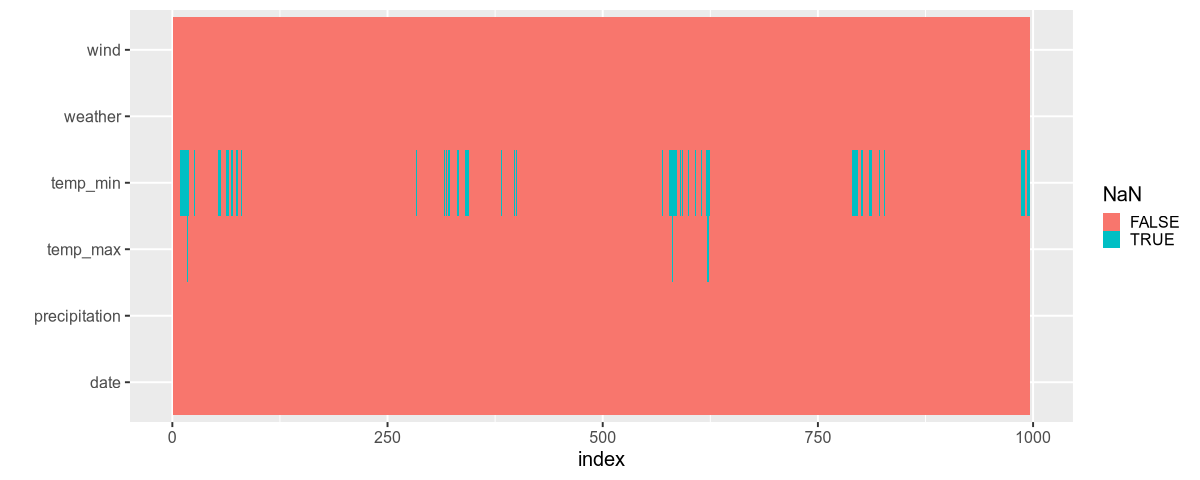

In [12]:
%%R -w 1200
theme_set(theme_gray(base_size = 20))

df |>
    map_df(is.na) |>
    mutate(index = row_number()) |>
    pivot_longer(-index) |>
    ggplot(aes(x = index, y = name, fill = value)) +
        geom_raster() +
        labs(y = '', fill = 'NaN')

Sorted by max temp:

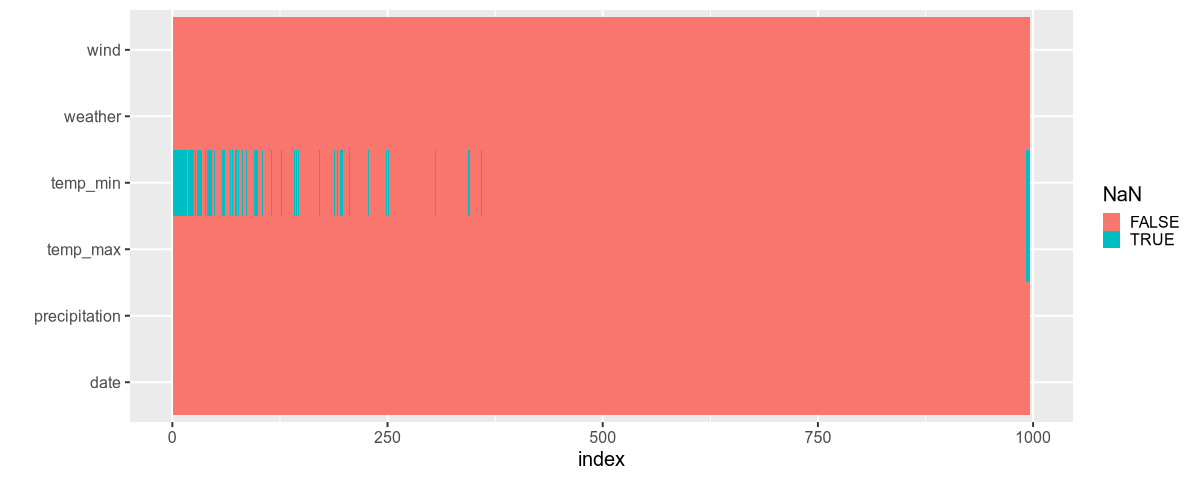

In [13]:
%%R -w 1200
theme_set(theme_gray(base_size = 20))

df |>
    arrange(temp_max) |>
    map_df(is.na) |>
    mutate(index = row_number()) |>
    pivot_longer(-index) |>
    ggplot(aes(x = index, y = name, fill = value)) +
        geom_raster() +
        labs(y = '', fill = 'NaN')

## Repeating the same plots for multiple dataframe columns

### Py

Previously we have made subplots via faceting,
which creates one subplot per unique value in a categorical column
and displays the same numerical columns in all the subplots/facets.
This view of multiple subsets in the data
is often called a trellis plot or plot of small multiples.
Here,
we will see how we can create subplots that each display all the data points,
but is repeated for different columns in the data.

We specify which columns we want to use via the `.repeat` method,
and where we want to use them via `alt.repeat`.
For this plot,
we keep the y-axis constant,
and repeat the plot for different x-axis columns.

In [14]:
url = 'https://raw.githubusercontent.com/joelostblom/teaching-datasets/main/movies.json'
movies = pd.read_json(url)[['runtime', 'budget', 'revenue', 'genres', 'countries']]
movies

,runtime,budget,revenue,genres,countries
0,100,94000000,940335536,[Animation],[United States of America]
1,143,140000000,655011224,[Fantasy],[United States of America]
2,87,75000000,527068851,[Animation],[United States of America]
3,151,200000000,1065659812,[Fantasy],[United States of America]
4,106,70000000,101371017,[Fantasy],[United States of America]
...,...,...,...,...,...
675,107,100000000,519876949,[History],"[United Kingdom, United States of America]"
676,86,50000000,66913939,[Animation],[United States of America]
677,100,22000000,194647323,[Fantasy],[United States of America]
678,72,3500000,3775000,[Animation],[United States of America]


In [15]:
# You could extract the columns like this, but we will write them out for clarity here
# numeric_cols = movies.select_dtypes('number').columns.tolist()
alt.Chart(movies).mark_bar().encode(
     alt.X(alt.repeat()).type('quantitative').bin(maxbins=40),
     y='count()',
).properties(
    width=300,
    height=200
).repeat(
    ['runtime', 'revenue', 'budget']
)

alt.RepeatChart(...)

### R

There is not "repeat" function in ggplot,
so we would first need to pivot all data frame variables
into the same column and then use faceting on this new column name.

In [16]:
%%R

library(rjson)
library(tidyverse)
theme_set(theme_gray(base_size = 16))


url <- 'https://raw.githubusercontent.com/joelostblom/teaching-datasets/main/movies.json'
movies <- fromJSON(file = url) %>%
    as_tibble() %>%
    select(runtime, revenue, budget, genres, countries) %>%
    unnest(-c(countries, genres))
glimpse(movies)

Rows: 680
Columns: 5
$ runtime   <dbl> 100, 143, 87, 151, 106, 119, 115, 178, 179, 201, 132, 101, 1…
$ revenue   <dbl> 940335536, 655011224, 527068851, 1065659812, 101371017, 7627…
$ budget    <dbl> 9.40e+07, 1.40e+08, 7.50e+07, 2.00e+08, 7.00e+07, 2.50e+07, …
$ genres    <named list> "Animation", "Fantasy", "Animation", "Fantasy", "Fant…
$ countries <named list> "United States of America", "United States of America…


In [17]:
%%R

movies_long <- movies |>
    select_if(is.numeric) |>
    pivot_longer(everything())  # To get only some columns we can write c(revenue, budget)

movies_long

# A tibble: 2,040 × 2
   name        value
   <chr>       <dbl>
 1 runtime       100
 2 revenue 940335536
 3 budget   94000000
 4 runtime       143
 5 revenue 655011224
 6 budget  140000000
 7 runtime        87
 8 revenue 527068851
 9 budget   75000000
10 runtime       151
# ℹ 2,030 more rows
# ℹ Use `print(n = ...)` to see more rows


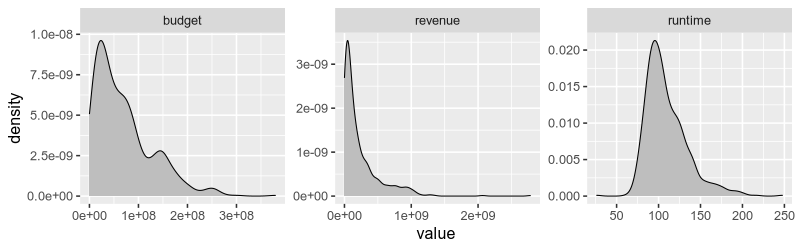

In [18]:
%%R -w 800 -h 250

movies_long |>
    ggplot(aes(x = value)) + 
        geom_density(fill = 'grey') + 
        facet_wrap(~name, scales = 'free')

### Repeating on two axes

#### Py

To efficiently repeat over both the axis,
we can use the `column` and `row` parameter to `repeat`.
These work similarly as they do for `facet`,
distributing the list of data frame variables 
over only one axis,
which we specify with `alt.repeat` to the x and y axis.

In [19]:
alt.Chart(movies).mark_point(opacity=0.3, size=10).encode(
     alt.X(alt.repeat()).type('quantitative'),
     y='revenue',
).properties(
    width=200,
    height=200
).repeat(
    ['runtime', 'revenue', 'budget']
)

alt.RepeatChart(...)

When we don't give any named parameters to `repeat` and `alt.repeat`,
they use the default,
which is `repeat` and then you can wrap with `columns=2` if you want more than one row.
We could use this technique to create a what is usually called a scatter plot matrix (or pairplot),
where we repeat numerical columns on both axes to investigate their pairwise relationships.

In [20]:
alt.Chart(movies).mark_point(opacity=0.3, size=10).encode(
     alt.X(alt.repeat('row')).type('quantitative'),
     alt.Y(alt.repeat('column')).type('quantitative')
).properties(
    width=200,
    height=200
).repeat(
    column=['runtime', 'revenue', 'budget'],
    row=['runtime', 'revenue', 'budget']
)

alt.RepeatChart(...)

In [21]:
alt.Chart(movies).mark_point(opacity=0.3, size=10).encode(
     alt.X(alt.repeat('column')).type('quantitative'),
     alt.Y(alt.repeat('row')).type('quantitative')
).properties(
    width=200,
    height=200
).repeat(
    row=['runtime', 'revenue', 'budget'],
    column=['runtime', 'revenue', 'budget']
)

alt.RepeatChart(...)

#### R

This would not work if both axes are numerical,
but luckiy there is an extension packagge for ggplot called GGally,
which can be used here.
It also plots the density curves on the diagonal and the correlations on top.

R[write to console]: Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



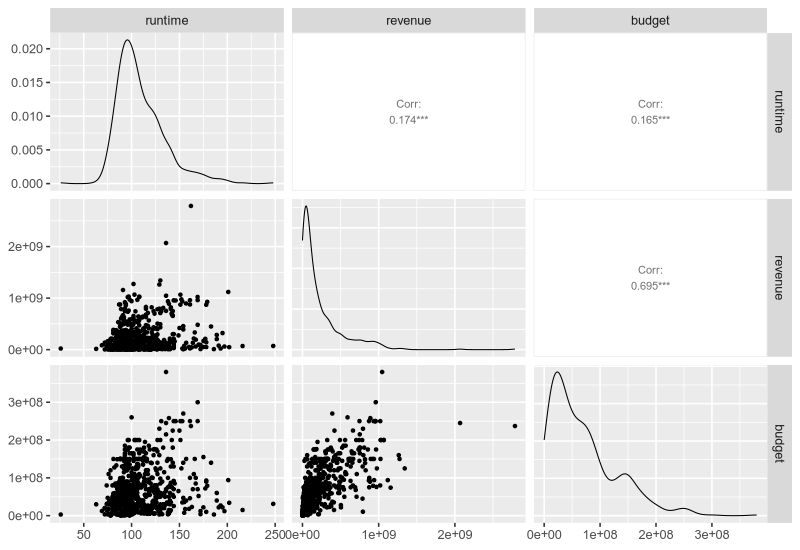

In [22]:
%%R -w 800 -h 550
library(GGally)
GGally::ggpairs(movies %>% select_if(is.numeric), progress = FALSE)

This function can also show info on categorical variables.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


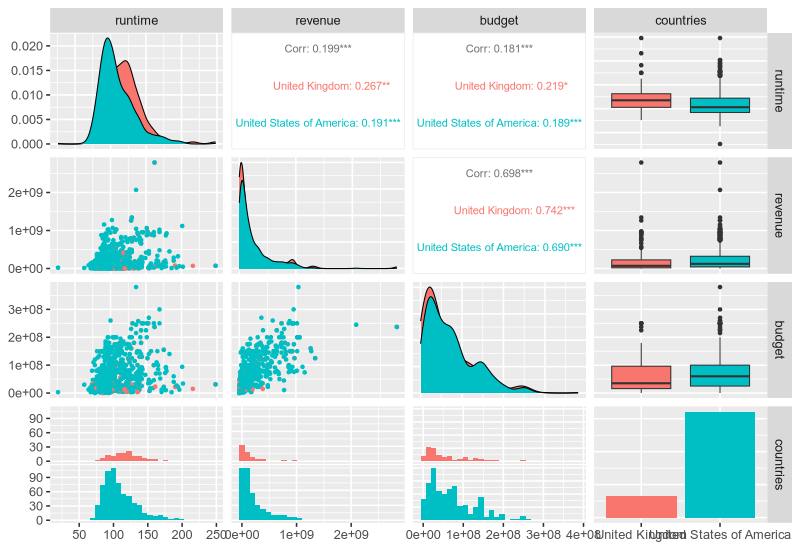

In [23]:
%%R -w 800 -h 550

free_countries <- movies %>% unnest(countries) %>% select(!genres)
GGally::ggpairs(free_countries, aes(color = countries), progress=FALSE)

Plotting multiple categories is also possible and will include counts of the combinations of categories as in the next plot.
Customizing these plots is a bit cumbersome,
[this blog post has some good examples](https://www.blopig.com/blog/2019/06/a-brief-introduction-to-ggpairs/),
and you can see one below too.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


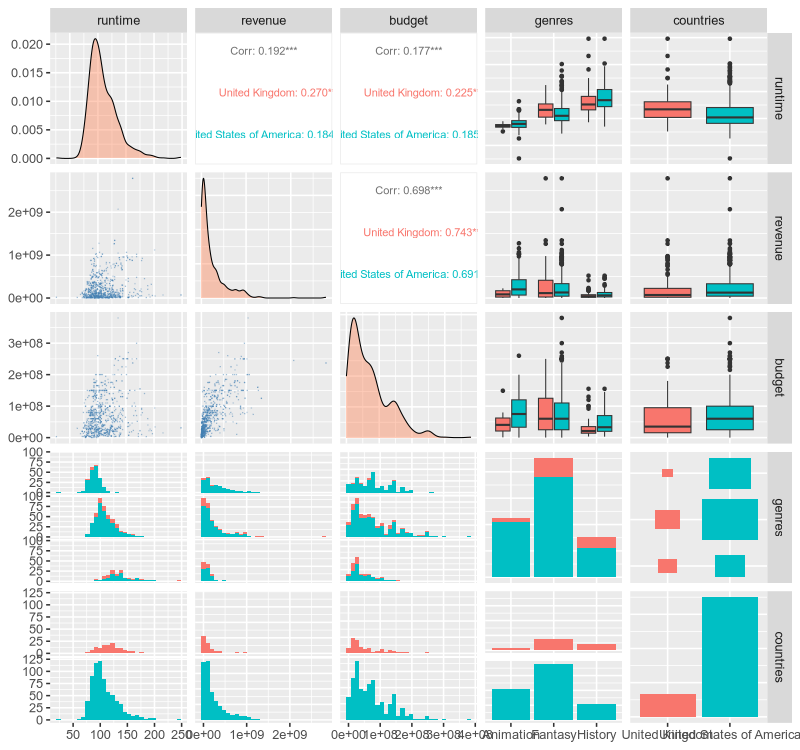

In [24]:
%%R -w 800 -h 750

free_both <- movies %>% unnest(genres) %>% unnest(countries)
GGally::ggpairs(
    free_both,
    aes(color = countries),
    progress = FALSE,
    lower = list(continuous = GGally::wrap('points', alpha = 0.3, size=0.1, color = 'steelblue')),
    diag = list(continuous = GGally::wrap('densityDiag', fill = 'coral', alpha = 0.4))) 

## Correlation plots

### Py

A good complement to a scatter plot matrix is a correlation plot
which helps formalize the correlation between numerical variables.
Using "spearman" correlation instead of "pearson" 
allows us to detect non-linear relationships better.

This can be done in pandas via the styler (requires matplotlib).

In [25]:
movies.corr(numeric_only=True).style.background_gradient()

,runtime,budget,revenue
runtime,1.000000,0.165387,0.174192
budget,0.165387,1.000000,0.694802
revenue,0.174192,0.694802,1.000000


We could do the same in Altair but it would require some more work

In [26]:
corr_df = (
    movies
    .corr('spearman', numeric_only=True)
    .abs()                      # Use abs for negative correlation to stand out
    .stack()                    # Get df into long format for altair
    .reset_index(name='corr'))  # Name the index that is reset to avoid name collision
corr_df

,level_0,level_1,corr
0,runtime,runtime,1.000000
1,runtime,budget,0.147367
2,runtime,revenue,0.106208
3,budget,runtime,0.147367
4,budget,budget,1.000000
5,budget,revenue,0.758968
6,revenue,runtime,0.106208
7,revenue,budget,0.758968
8,revenue,revenue,1.000000


In [27]:
alt.Chart(corr_df).mark_circle().encode(
    x='level_0',
    y='level_1',
    size='corr',
    color='corr'
)

alt.Chart(...)

With some effort, we can make it look nicer and remove the correlation on the diagonal since that is just with the same column.

In [28]:
corr_df = movies.select_dtypes('number').corr('spearman', numeric_only=True).stack().reset_index(name='corr')
corr_df.loc[corr_df['corr'] == 1, 'corr'] = 0  # Remove diagonal
corr_df['abs'] = corr_df['corr'].abs()
corr_df

,level_0,level_1,corr,abs
0,runtime,runtime,0.000000,0.000000
1,runtime,budget,0.147367,0.147367
2,runtime,revenue,0.106208,0.106208
3,budget,runtime,0.147367,0.147367
4,budget,budget,0.000000,0.000000
5,budget,revenue,0.758968,0.758968
6,revenue,runtime,0.106208,0.106208
7,revenue,budget,0.758968,0.758968
8,revenue,revenue,0.000000,0.000000


In [29]:
alt.Chart(corr_df).mark_circle().encode(
    x='level_0',
    y='level_1',
    size=alt.Size('abs').scale(domain=(0, 1)),
    color=alt.Color('corr').scale(scheme='blueorange', domain=(-1, 1))
)

alt.Chart(...)

The domain argument sets the extent of the colorscale
(from a perfect negative to a perfect positive correlation), 
we will talk more about colorscale later in the course.

### R

We could do the separate calculation in ggplot as well,
but there is also a special function in GGally,
which does the computation and visualizes it as a heatmap.

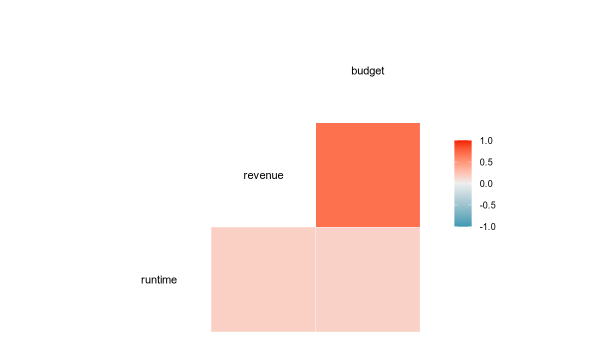

In [30]:
%%R -w 600 -h 350
GGally::ggcorr(movies)

## Counting combinations of categorical groups

### Py

Counting categoricals is helpful to get and overview of where most observations lie.
Often the size and color can be used for this, 
similar to the correlation plot.

In [31]:
boom_both = movies.explode('countries').explode('genres')
alt.Chart(boom_both).mark_square().encode(
    x='genres',
    y='countries',
    color='count()',
    size='count()'
)

alt.Chart(...)

As with bar charts of counts,
it is often helpful to sort these categorical plot according to which combinations have the most counts.
Here we can sort based on the `color` or `size` encoding,
just as we have sorted based on `x` and `y` before
(the effect of this sorting is more notable in larger charts).

In [32]:
boom_both = movies.explode('countries').explode('genres')
alt.Chart(boom_both).mark_square().encode(
    x=alt.X('genres').sort('-color'),
    y=alt.Y('countries').sort('color'),
    color='count()',
    size='count()'
)

alt.Chart(...)

A heatmap could be created as well,
but it can be a little harder to see the difference here
sine we are not using size for the count,
just color variations.

In [33]:
alt.Chart(boom_both).mark_rect().encode(
    x='genres',
    y='countries',
    color='count()'
)

alt.Chart(...)

For more precise counts,
we could use a faceted bar chart.

In [34]:
alt.Chart(boom_both).mark_bar().encode(
    x='count()',
    y='genres',
    color='genres'
).facet(
    'countries',
    columns=1
)

alt.FacetChart(...)

### R

GGally has a similar plot for counting categories.

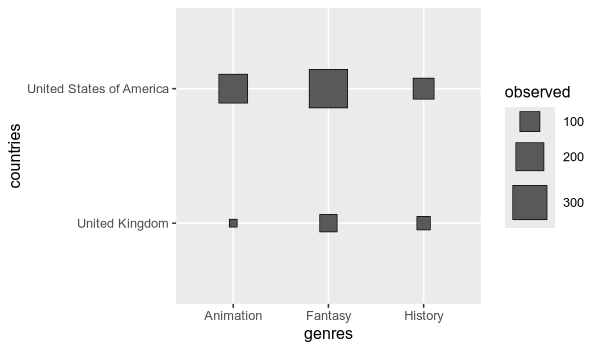

In [35]:
%%R -w 600 -h 350

free_both <- movies %>% unnest(genres) %>% unnest(countries)
GGally::ggally_cross(free_both, aes(x = genres, y = countries))

We can create an heatmap using ggplot's `geom_tile` together with `add_count` (remember that this function adds the count in a column names `n`).

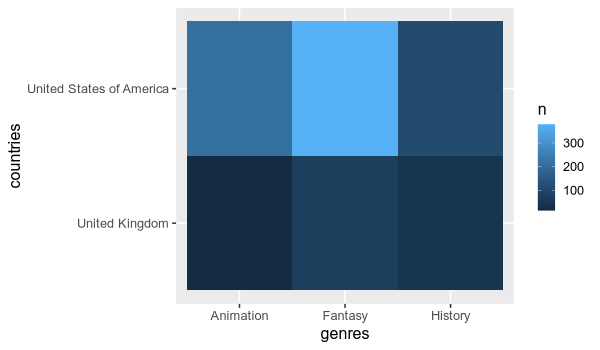

In [36]:
%%R -w 600 -h 350

free_both %>%
    add_count(genres, countries) %>%
    ggplot() +
        aes(x = genres,
            y = countries,
            fill = n) +
        geom_tile()

A barplot of counts could be made in ggplot without faceting by using `'dodge'` for he `position`.
The `color` parameter is used to create visual separation between the bars with a white outline.

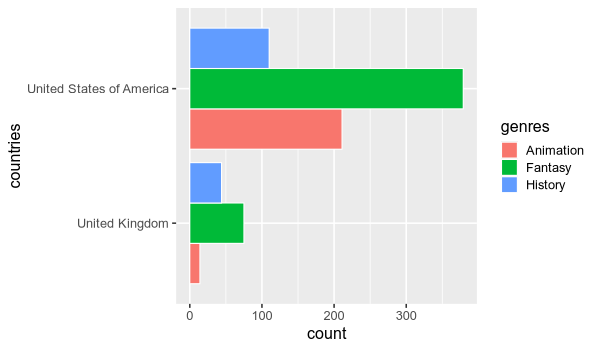

In [37]:
%%R -w 600 -h 350

ggplot(free_both) +
    aes(y = countries,
        fill = genres) +
    geom_bar(stat = 'count', position = 'dodge', color = 'white')

## Optional material

In addition to the `ggally` package,
there are a few other packages in both R and Python
that facilitate quick EDA and missing value visualization.
As long as you understand the underlying principles you are free 
to use any of these:

In [40]:
import altair_ally as aly

aly.nan(df.sort_values('temp_max', ignore_index=True))

alt.HConcatChart(...)

In [41]:
aly.pair(movies)

alt.VConcatChart(...)

Python

- https://github.com/ResidentMario/missingno
- https://github.com/ydataai/pandas-profiling
- https://github.com/fbdesignpro/sweetviz
- https://github.com/AutoViML/AutoViz
- https://github.com/ing-bank/popmon
- https://github.com/joelostblom/altair_ally
- https://github.com/lux-org/lux

R

- https://github.com/ggobi/ggally/
- https://github.com/statistikat/VIM (https://www.datacamp.com/tutorial/visualize-data-vim-package)

Some of them go to great length to facilitate the creation of quick EDA visualizations:

![](https://raw.githubusercontent.com/lux-org/lux-resources/master/readme_img/basicDemo.gif)